In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from keras.models import Model,Sequential
from keras.utils import to_categorical

C:\Users\MengnanChen\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%matplotlib inline

In [5]:
image_shape=(28,28,1)

latent_dim=2

batch_size=32

In [6]:
def create_encoder():
    # q(t_i)=N(t_mean,t_log_var)
    # image -> CNN -> (t_mean & t_log_var)
    encoder_input=layers.Input(shape=image_shape)
    
    x=layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(encoder_input)
    x=layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
    x=layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x=layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x=layers.Flatten()(x)
    x=layers.Dense(32,activation='relu')(x)
    
    t_mean=layers.Dense(latent_dim)(x)
    t_log_var=layers.Dense(latent_dim)(x)
    
    return Model(inputs=encoder_input,outputs=[t_mean,t_log_var],name='encoder')

In [7]:
def create_decoder():
    # input: hidden state, t
    # output: image
    decoder_input=layers.Input(shape=(latent_dim,))
    
    x=layers.Dense(12544,activation='relu')(decoder_input)  # 12544=14*14*64
    x=layers.Reshape((14,14,64))(x)
    x=layers.Conv2DTranspose(32,3,padding='same',activation='relu',strides=(2,2))(x)
    x=layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)
    
    return Model(decoder_input,x,name='decoder')

In [8]:
def sample(args):
    # t_i=g(m(x_i,\phi),s(x_i,\phi))=m(x_i,\phi)+\epsilon *s(x_i,\phi)
    t_mean,t_log_var=args
    t_sigma=K.sqrt(K.exp(t_log_var))
    epsilon=K.random_normal(shape=K.shape(t_mean),mean=0.,stddev=1.)
    return t_mean+t_sigma*epsilon

def create_sampler():
    '''
    定义关于随机变量ε和变换函数g(.)的采样器
    '''
    return layers.Lambda(sample,name='sampler')

In [27]:
# 编码器 + 解码器 + 采样器
encoder=create_encoder()
decoder=create_decoder()
sampler=create_sampler()

x=layers.Input(shape=image_shape)
t_means,t_log_var=encoder(x)
t=sampler([t_means,t_log_var])
t_decoded=decoder(t)

vae=Model(inputs=x,outputs=t_decoded,name='vae')

In [28]:
# 定义变分下界作为优化的目标函数
def neg_variational_lower_bound(x,t_decoded):
    # reconstruction loss
    rc_loss=K.sum(K.binary_crossentropy(K.batch_flatten(x),
                                       K.batch_flatten(t_decoded)),axis=-1)
    # regularization term (KL divergence)
    kl_loss=-0.5*K.sum(1+t_log_var-K.square(t_means)-K.exp(t_log_var),axis=-1)
    
    return K.mean(rc_loss+kl_loss)

In [38]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=x_train.astype('float32')/255.

In [30]:
x_train.shape

(60000, 28, 28)

In [31]:
x_test.shape

(10000, 28, 28)

In [32]:
x_train.shape+(1,)

(60000, 28, 28, 1)

In [33]:
x_train=x_train.reshape(x_train.shape+(1,))

x_test=x_test.astype('float32')/255.
x_test=x_test.reshape(x_test.shape+(1,))

vae.compile(optimizer='rmsprop',loss=neg_variational_lower_bound)
vae.fit(x=x_train,
       y=x_train,
       epochs=1,
       shuffle=True,
       batch_size=batch_size,
       validation_data=(x_test,x_test),verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 432s - loss: 240.4783 - val_loss: 163.1199


In [34]:
t_test=encoder.predict(x_test)

In [35]:
t_test

[array([[ 0.8657164 , -2.1846774 ],
        [ 0.26776958,  0.9860247 ],
        [-2.8759682 , -1.9707661 ],
        ...,
        [ 0.23262829, -1.0118859 ],
        [-1.8124031 ,  0.72161007],
        [-0.27580222,  1.6093861 ]], dtype=float32),
 array([[-4.6228867, -4.5712843],
        [-5.5379543, -5.9082193],
        [-2.3681467, -3.87314  ],
        ...,
        [-4.4495296, -5.4004393],
        [-4.277126 , -4.942155 ],
        [-5.373926 , -4.569811 ]], dtype=float32)]

In [36]:
t_test=t_test[0]

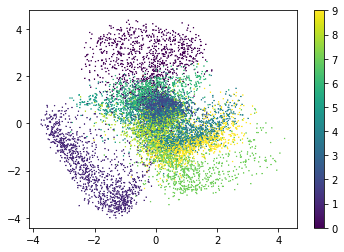

In [39]:
plt.scatter(t_test[:,0],t_test[:,1],marker='x',s=0.2,c=y_test)
plt.colorbar()

In [40]:
from scipy.stats import norm

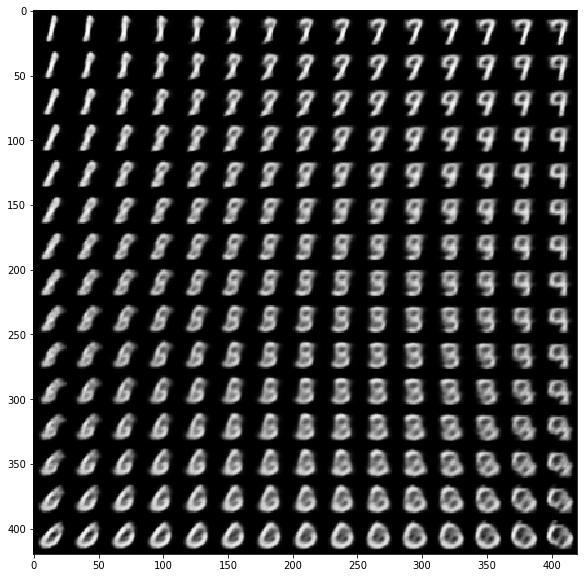

In [42]:
n=15  # number of samples per dimension

grid_x=norm.ppf(np.linspace(0.05,0.95,n))
grid_y=norm.ppf(np.linspace(0.05,0.95,n))

digit_size=28
figure=np.zeros((digit_size*n,digit_size*n))
for i,yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        # for one loop, one digit image will be generated.
        t_sample=np.array([[xi,yi]])
        t_sample=np.tile(t_sample,batch_size).reshape(batch_size,latent_dim)
        t_decoded=decoder.predict(t_sample,batch_size=batch_size)
        digit=t_decoded[0].reshape(digit_size,digit_size)
        figure[i*digit_size:(i+1)*digit_size,
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure,cmap='Greys_r')

In [43]:
grid_x=norm.ppf(np.linspace(0.05,0.95,10))

In [45]:
grid_x.shape

(10,)

In [46]:
grid_x

array([-1.64485363, -1.03643339, -0.67448975, -0.38532047, -0.12566135,
        0.12566135,  0.38532047,  0.67448975,  1.03643339,  1.64485363])

In [47]:
t_sample=np.array([[0,1]])

In [48]:
t_sample

array([[0, 1]])

In [49]:
t_sample=np.tile(t_sample,8)

In [50]:
t_sample

array([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])

In [51]:
t_sample.reshape(8,2)

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])